In [2]:
%cd ../../../

/home/schilcherj/master/deepClustering/LMU_Master_Practical_SoSe24


/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
%load_ext autoreload
%autoreload 2
from practical.DeepClustering.DipECT.dipect import Cluster_Tree, DipECT
from clustpy.deep._data_utils import get_dataloader
from clustpy.data.real_torchvision_data import load_mnist
from clustpy.deep.dipencoder import _Dip_Gradient, dip_test
from clustpy.deep.autoencoders import FeedforwardAutoencoder
import numpy as np
from sklearn.cluster import KMeans
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from clustpy.metrics import unsupervised_clustering_accuracy
import random
import umap
from sklearn.decomposition import PCA


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def get_inital_projection_axis(X_embedd):
        """
        Returns the inital projection axis for the data in the given trainloader. Furthermore, the size of the higher projection cluster and the lower projection cluster will be returned (e.g to initialise pruning indicator).
        """
        # init projection axis on full dataset
        kmeans = KMeans(n_clusters=2, n_init=10).fit(X_embedd)
        kmeans_centers = kmeans.cluster_centers_
        labels = kmeans.labels_
        axis = kmeans_centers[1] - kmeans_centers[0]
        # identify which cluster is better alligned with the projection axis, i.e. which has the higher projection score to return the initial assignment size correctly
        projections = X_embedd @ axis.reshape(-1,1)
        projections_0_mean = np.mean(projections[labels==0])
        projections_1_mean = np.mean(projections[labels==1])
        higher_projection_cluster = 1 if projections_1_mean > projections_0_mean else 0
        return kmeans_centers[0] - kmeans_centers[1], kmeans_centers[0], kmeans_centers[1]
def predict_subclusters(data, axis):
        projections = data @ axis
        sorted_indices = projections.argsort()
        dip_value, modal_interval, modal_triangle = dip_test(projections[sorted_indices], is_data_sorted=True, just_dip=False)
        index_lower, index_upper = modal_interval
        index_tri1, index_tri2, index_tri3 = modal_triangle
        if projections[sorted_indices[index_tri2]] > projections[sorted_indices[index_upper]]:
                treshhold =  (projections[sorted_indices[index_tri2]] + projections[sorted_indices[index_upper]])/2
        else:
                treshhold =  (projections[sorted_indices[index_tri2]] + projections[sorted_indices[index_lower]])/2
        labels = np.zeros(len(data))
        labels[projections >= treshhold] = 1
        labels[sorted_indices[index_tri2]] = 2
        labels[sorted_indices[index_lower]] = 3
        labels[sorted_indices[index_upper]] = 3
        return labels


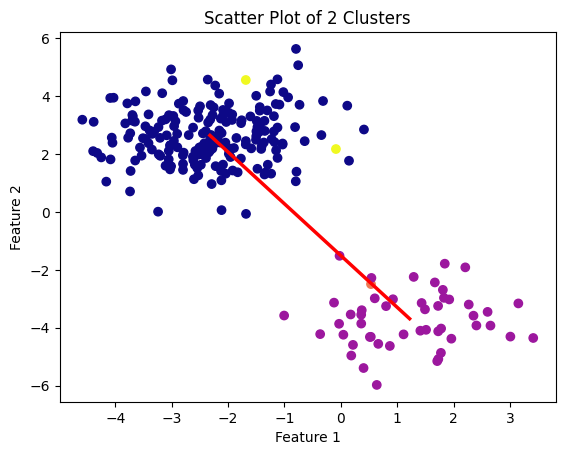

In [5]:


# Generate sample data
# X, y = make_blobs(n_samples=300, centers=2)
# Generate sample data with clusters of different sizes
X1, y1 = make_blobs(n_samples=50, centers=1,)
X2, y2 = make_blobs(n_samples=200, centers=1, )

# Combine the datasets
X = np.vstack((X1, X2))
y = np.hstack((y1, y2 + 1))  # Adjust labels for the second cluster

axis, c1, c2 = get_inital_projection_axis(X)

labels = predict_subclusters(X, axis)


# Create a scatter plot
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='plasma', marker='o')

# origin = [np.mean(X, axis=0)[0]], [np.mean(X, axis=0)[1]]  # Vector origin point
# plt.quiver(*origin, axis[0], axis[1], scale=5, color='red', label='Direction Vector')
plt.plot([c1[0], c2[0]], [c1[1], c2[1]], color='red',linewidth=2.5, label='Line between points')

# Add title and labels
plt.title('Scatter Plot of 2 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Show plot
plt.show()

True
1.0


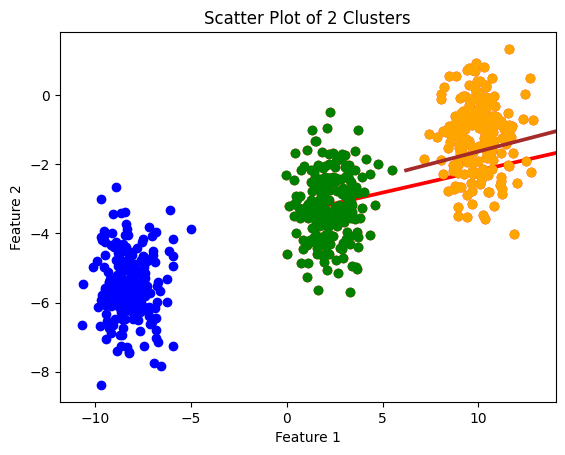

In [6]:
# Generate sample data
X, y = make_blobs(n_samples=600, centers=3)

# X1, y1 = make_blobs(n_samples=50, centers=1)
# X2, y2 = make_blobs(n_samples=200, centers=1)
# X3, y3 = make_blobs(n_samples=100, centers=1)
# X4, y4 = make_blobs(n_samples=250, centers=1)

# Combine the datasets
# X = np.vstack((X1, X2, X3, X4))
# y = np.hstack((y1, y2 + 1, y3 + 2, y4 + 3))  

dataloader = get_dataloader(X, 50 )
encode = lambda x: x
autoencoder = type("Autoencoder", (), {"encode": encode})

tree = Cluster_Tree(dataloader, autoencoder, None, "cpu")

tree.assign_to_tree(torch.from_numpy(X))

# Create a scatter plot
plt.scatter(tree.root.lower_projection_child.assignments[:, 0], tree.root.lower_projection_child.assignments[:, 1], c="blue", marker='o')
plt.scatter(tree.root.higher_projection_child.assignments[:, 0], tree.root.higher_projection_child.assignments[:, 1], c="red", marker='o')

origin = [np.mean(X, axis=0)[0]], [np.mean(X, axis=0)[1]]  # Vector origin point
plt.quiver(*origin, tree.root.projection_axis.data[0], tree.root.projection_axis.data[1], scale=5, color='red', label='Direction Vector')

# Add title and labels
plt.title('Scatter Plot of 2 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Show plot


tree.grow_tree(dataloader, autoencoder, None, 0.0)
tree.assign_to_tree(torch.from_numpy(X))

pred_labels = np.ones(len(X))*-1

if tree.root.lower_projection_child.is_leaf_node():
    plt.scatter(tree.root.higher_projection_child.lower_projection_child.assignments[:, 0],tree.root.higher_projection_child.lower_projection_child.assignments[:, 1], c="green", marker='o')
    plt.scatter(tree.root.higher_projection_child.higher_projection_child.assignments[:, 0], tree.root.higher_projection_child.higher_projection_child.assignments[:, 1], c="orange", marker='o')

    origin = [np.mean(tree.root.higher_projection_child.assignments.numpy(), axis=0)[0]], [np.mean(tree.root.higher_projection_child.assignments.numpy(), axis=0)[1]]  # Vector origin point
    plt.quiver(*origin, tree.root.higher_projection_child.projection_axis.data[0], tree.root.higher_projection_child.projection_axis.data[1], scale=5, color='brown', label='Direction Vector')
    X_combined = torch.cat((tree.root.higher_projection_child.lower_projection_child.assignments, tree.root.higher_projection_child.higher_projection_child.assignments), dim=0)
    
    X_combined_sorted, _ = torch.sort(X_combined, dim=0)
    X_sorted, _ = torch.sort(tree.root.higher_projection_child.assignments, dim=0)

    # Check if the sorted tensors are identical
    is_identical = torch.equal(X_sorted, X_combined_sorted)
    print(is_identical)
    pred_labels[tree.root.higher_projection_child.lower_projection_child.assignment_indices] = 0
    pred_labels[tree.root.higher_projection_child.higher_projection_child.assignment_indices] = 1
    pred_labels[tree.root.lower_projection_child.assignment_indices] = 2
else:
    plt.scatter(tree.root.lower_projection_child.lower_projection_child.assignments[:, 0],tree.root.lower_projection_child.lower_projection_child.assignments[:, 1], c="green", marker='o')
    plt.scatter(tree.root.lower_projection_child.higher_projection_child.assignments[:, 0], tree.root.lower_projection_child.higher_projection_child.assignments[:, 1], c="orange", marker='o')
    origin = [np.mean(tree.root.lower_projection_child.assignments.numpy(), axis=0)[0]], [np.mean(tree.root.lower_projection_child.assignments.numpy(), axis=0)[1]]  # Vector origin point
    plt.quiver(*origin, tree.root.lower_projection_child.projection_axis.data[0], tree.root.lower_projection_child.projection_axis.data[1], scale=5, color='brown', label='Direction Vector')

    X_combined = torch.cat((tree.root.lower_projection_child.lower_projection_child.assignments, tree.root.lower_projection_child.higher_projection_child.assignments), dim=0)

    X_combined_sorted, _ = torch.sort(X_combined, dim=0)
    X_sorted, _ = torch.sort(tree.root.lower_projection_child.assignments, dim=0)

    # Check if the sorted tensors are identical
    is_identical = torch.equal(X_sorted, X_combined_sorted)
    print(is_identical)
    pred_labels[tree.root.lower_projection_child.lower_projection_child.assignment_indices] = 0
    pred_labels[tree.root.lower_projection_child.higher_projection_child.assignment_indices] = 1
    pred_labels[tree.root.higher_projection_child.assignment_indices] = 2

print(unsupervised_clustering_accuracy(y, pred_labels))
plt.show()


In [7]:
data = load_mnist()["data"]
encode = lambda x: x
autoencoder = type("Autoencoder", (), {"encode": encode})

tree = Cluster_Tree(dataloader, autoencoder, None, "cpu")

In [42]:
dataset, labels = load_mnist("train", return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./pretrained_AE.pth"))
autoencoder.fitted = True

dipect = DipECT(autoencoder=autoencoder, grow_interval=100, max_iterations=1000) # wenn batch_size=len(dataset), cluster loss fällt monoton
dipect = dipect.fit_predict(dataset)

cpu


Fit:   0%|          | 2/1000 [00:00<04:20,  3.84it/s]

2.0648629665374756
0.02929188683629036


Fit:   0%|          | 3/1000 [00:00<03:12,  5.18it/s]

1.5246039628982544
0.011829055845737457
1.3437379002571106
-0.013368923217058182


Fit:   0%|          | 5/1000 [00:00<02:33,  6.46it/s]

1.2559653371572495
0.00624331459403038
1.2008409023284912
0.003797236829996109
1.1714945435523987
0.01916886866092682


Fit:   1%|          | 9/1000 [00:01<01:48,  9.14it/s]

1.144492038658687
0.009295914322137833
1.1260815560817719
0.00774393230676651
1.1190846628612943
0.03370850905776024


Fit:   1%|          | 12/1000 [00:01<01:41,  9.75it/s]

1.110293412208557
0.026004333049058914


Fit:  10%|█         | 101/1000 [00:36<24:49,  1.66s/it]

0.962515395283699
-0.05979553982615471


Fit:  20%|██        | 201/1000 [01:00<34:52,  2.62s/it]

0.8977854162454605
-0.207848459482193


Fit:  30%|███       | 301/1000 [02:19<42:22,  3.64s/it]  

0.8243903348843257
-0.3165692389011383


Fit:  40%|████      | 401/1000 [02:45<34:41,  3.47s/it]

0.7264796472340822
-0.6527324318885803


Fit:  50%|█████     | 501/1000 [03:15<29:14,  3.52s/it]

0.6072712823748588
-1.2389533519744873


Fit:  60%|██████    | 601/1000 [03:48<26:36,  4.00s/it]

0.47536909028887747
-1.5486822128295898


Fit:  70%|███████   | 701/1000 [04:23<22:34,  4.53s/it]

0.3475144262398992
-1.925046443939209


Fit:  80%|████████  | 801/1000 [05:11<14:54,  4.49s/it]

0.20540644753724335
-2.1162214279174805


Fit:  90%|█████████ | 901/1000 [05:46<07:34,  4.59s/it]

0.06194965644015206
-2.66011381149292


Fit: 100%|██████████| 1000/1000 [06:10<00:00,  5.27it/s]

-0.09906224915385246
-2.795874834060669


Fit: 1001it [06:32,  2.55it/s]                          
Predict: 100%|██████████| 235/235 [00:06<00:00, 36.41it/s]


In [44]:
print(dipect.tree_.flat_accuracy(labels, 10))
print(dipect.tree_.flat_nmi(labels, 10))

0.6769833333333334
0.7149087735926066


In [9]:
dataset, labels = load_mnist("train", return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True

dipect = DipECT(autoencoder=autoencoder, grow_interval=300, max_iterations=10000) # wenn batch_size=len(dataset), cluster loss fällt monoton
dipect = dipect.fit_predict(dataset)

cpu


Fit:   0%|          | 5/10000 [00:00<11:21, 14.67it/s]

2.0648627281188965
0.02929188311100006
1.5246037542819977
0.011829063296318054
1.3437376817067463
-0.01336883008480072
1.2559651583433151
0.006243336945772171


Fit:   0%|          | 9/10000 [00:00<09:49, 16.95it/s]

1.2008407354354858
0.0037973113358020782
1.1714943448702495
0.019168749451637268
1.1444918342999049
0.009295932948589325
1.1260813400149345
0.007743775844573975


Fit:   0%|          | 13/10000 [00:00<09:21, 17.78it/s]

1.11908444431093
0.03370852395892143
1.1102931916713714
0.0260043665766716


Fit:   1%|          | 103/10000 [00:05<11:08, 14.81it/s]

0.9629341375827789
-0.02534998208284378


Fit:   1%|▏         | 146/10000 [00:08<09:42, 16.93it/s]


KeyboardInterrupt: 

In [38]:
dipect.tree_.flat_accuracy(labels, 10)

0.5141833333333333

In [39]:
dipect.tree_.flat_nmi(labels, 10)

0.6708468516249979

In [33]:
def visualize_peformance_AE(
    autoencoder,
    samples,
    labels,
    image_size: tuple,
    number_samples: int,
    seed: int = None,
):


    if seed is not None and type(seed) == int:
        random.seed(seed)

   
    fig, ax = plt.subplots(2, number_samples)
    fig.tight_layout()
    ax = ax.flatten()
    with torch.no_grad():
        for i, index in enumerate(
            sorted(random.sample(range(samples.shape[0]), number_samples))
        ):
            img = samples[index]
            if img.ndim == 1:
                img = np.expand_dims(img, 0)
            img_rec = (
                autoencoder.decode(autoencoder.encode(torch.from_numpy(img)))
                .cpu()
                .numpy()
            )
            ax[i].imshow(img.reshape(image_size[0], image_size[1]), cmap="gray")
            ax[i + number_samples].imshow(
                img_rec.reshape(image_size[0], image_size[1]), cmap="gray"
            )
            ax[i].set_title(f"original")
            ax[i + number_samples].set_title(f"reconstructed")
            ax[i].set_axis_off()
            ax[i + number_samples].set_axis_off()

        embeddings = []

        for batch in torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.tensor(samples, dtype=torch.float32)),
            batch_size=256,
        ):
            embeddings.append(autoencoder.encode(batch[0]).cpu().numpy())

    embeddings = np.concatenate(embeddings)
    # PCA of embedded space
    print("fitting pca")
    plt.figure()
    pca = PCA(n_components=2)
    projected_data = pca.fit_transform(embeddings)
    plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap="viridis")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA of embedded space")
    plt.colorbar(label="Digit")
    plt.show()
    print("fitted pca")

    print("fitting umap")
    plt.figure()
    projected_data = umap.UMAP().fit_transform(embeddings)
    plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap="viridis")
    plt.xlabel("umap feature 1")
    plt.ylabel("umap feature 2")
    plt.title("umap of embedded space")
    plt.colorbar(label="Digit")
    plt.show()
    print("fitted umap")


fitting pca


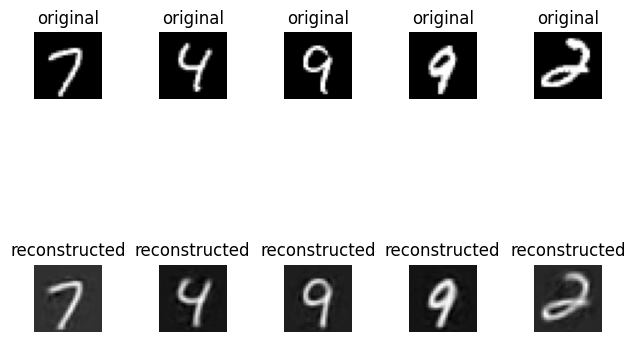

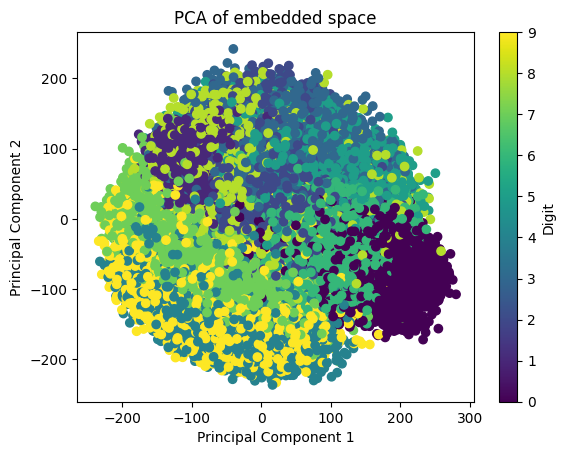

fitted pca
fitting umap


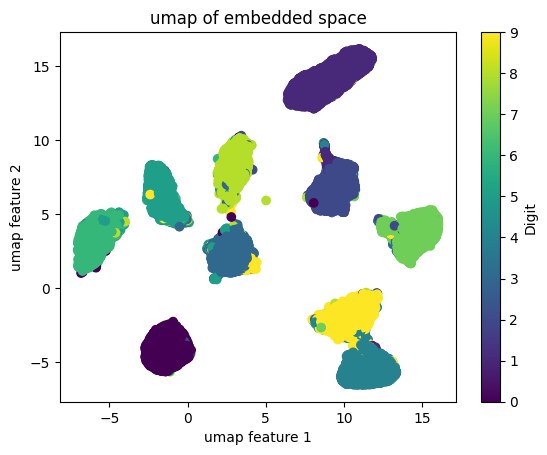

fitted umap
fitting pca


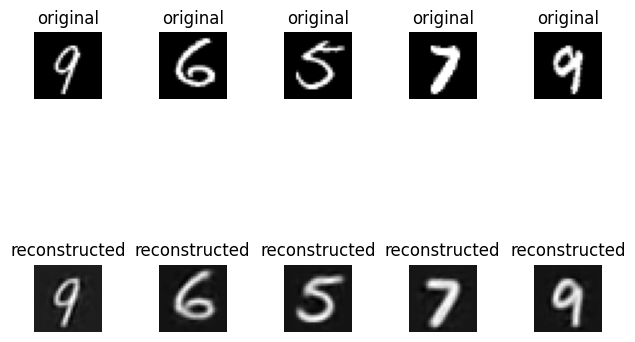

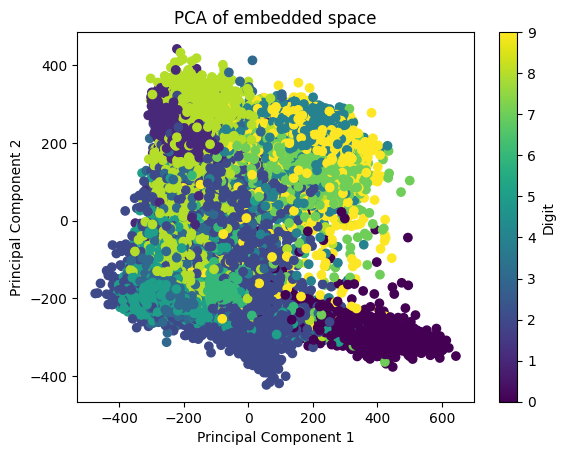

fitted pca
fitting umap


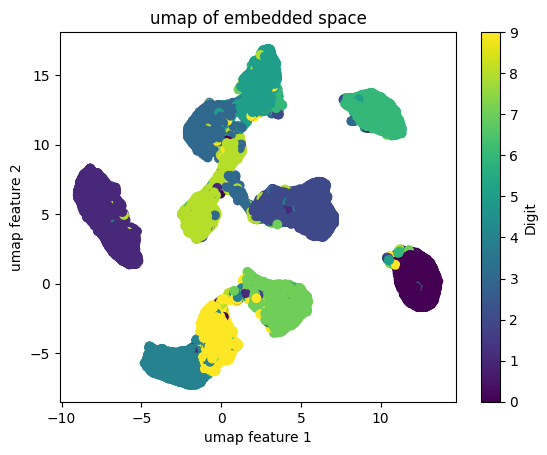

fitted umap


In [40]:
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./pretrained_AE.pth"))
autoencoder.fitted = True
visualize_peformance_AE(autoencoder, dataset, labels, (28,28), 5)

visualize_peformance_AE(dipect.autoencoder, dataset, labels, (28,28), 5)